In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy.io import savemat

In [56]:
class ModelEvaluator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.models = {
            "Linear Regression": LinearRegression(),
            "Lasso": Lasso(random_state=0),
            "Decision Tree": DecisionTreeRegressor(random_state=0),
            "Random Forest": RandomForestRegressor(random_state=0),
            "Gradient Boosting": GradientBoostingRegressor(random_state=0),
            "SVR": SVR(),
            "KNN": KNeighborsRegressor(),
        }
        self.loo = LeaveOneOut()
        self.scaler = StandardScaler()   
        
    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        self.df = self.df[self.df['survival_time'] <= 1280]
    
    def perform_loocv(self):
        results = {}
        for model_name, model in self.models.items():
            predictions = []
            actuals = []
            for train_index, test_index in self.loo.split(self.X):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

                # Standardize the training data and apply the same transformation to the test data
                X_train_scaled = self.scaler.fit_transform(X_train)
                X_test_scaled = self.scaler.transform(X_test)

                # Train model on scaled data
                model.fit(X_train_scaled, y_train)

                # Predict using scaled test data
                y_pred = model.predict(X_test_scaled)
                predictions.append(y_pred[0])
                actuals.append(y_test.iloc[0])

            # Compute MSE
            mse = mean_squared_error(actuals, predictions)
            results[model_name] = {
                "predictions": predictions,
                "actuals": actuals,
                "mse": mse
            }
            print(f"Model: {model_name}, MSE: {mse:.4f}")

        return results

    def calculate_std(self, model_name):
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found in evaluator.")

        predictions = []
        actuals = []
        for train_index, test_index in self.loo.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

            # Standardize the training data and apply the same transformation to the test data
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            # Train model on scaled data
            self.models[model_name].fit(X_train_scaled, y_train)

            # Predict using scaled test data
            y_pred = self.models[model_name].predict(X_test_scaled)
            predictions.append(y_pred[0])
            actuals.append(y_test.iloc[0])

        # Calculate residuals
        residuals = np.array(actuals) - np.array(predictions)
        std = np.std(residuals)
        print(f"Standard Deviation of residuals for {model_name}: {std:.4f}")
        
        return std

    def save_all_pdf_data(self, model_name, pdf_disc=100, save_path='Reg_thesis.mat'):
        results = self.perform_loocv()
        std = self.calculate_std(model_name)

        if model_name in results:
            predictions = results[model_name]["predictions"]
            actuals = results[model_name]["actuals"]
            pdf_data = {}
            Survival_days_range = np.linspace(0, 45, pdf_disc)
            
            pdf_cells = []
            for i, y_pred in enumerate(predictions):
                y_true = actuals[i]
                pdf_values = norm.pdf(Survival_days_range, y_pred, std)
                pdf_cells.append(pdf_values)

            # Save the PDF data to a .mat file
            savemat(save_path, {'pdf_cells': pdf_cells})
            print(f"PDF data saved to {save_path}")

    def plot_pdf(self, model_name, patient_index, pdf_disc=100):
        results = self.perform_loocv()
        std = self.calculate_std(model_name)

        if model_name in results:
            predictions = results[model_name]["predictions"]
            actuals = results[model_name]["actuals"]
            y_pred = predictions[patient_index]
            y_true = actuals[patient_index]

            # Define the range for the PDF
            Survival_days_range = np.linspace(0, 45, pdf_disc)
            pdf_values = norm.pdf(Survival_days_range, y_pred, std)

            plt.figure(figsize=(10, 6))
            plt.plot(Survival_days_range, pdf_values, label=f'PDF for patient {patient_index}')
            plt.axvline(y_true, color='b', linestyle='--', label=f'True value: {y_true:.4f}')
            plt.title(f'Probability Density Function for {model_name} (Patient {patient_index})\nTrue value: {y_true:.4f}')
            plt.xlabel('Predicted Value')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
        else:
            print(f"No results found for model {model_name}")


file_path = 'F:\\Olivier\\dataset_thesis_complete.csv'

In [58]:
# Extract features and target for model evaluation
df = pd.read_csv(file_path)
df = df[df['survival_time'] <= 1280]
X = df.drop(columns=['patient_id','growth','LAST_MR','survival_time',"Infiltration",'Time','Vol_FL','Vol_T1','mu1','mu2','X','Y','Z','mu1mu2','PC1','PC2','PC4','Vol_rat2','Vol_rat'])
y = df['LAST_MR']/30
X.head()

,PC3,Age,sex,Total_resection,Vol_Nec,mu2mu1
0,10.171185,52,1,95.0,1.470,0.474432
2,-9.936605,46,0,60.0,30.670,0.191663
3,-9.511910,62,0,20.0,33.145,1.430863
4,-4.527472,72,0,95.0,5.416,0.106904
5,-8.696319,55,1,98.0,35.087,0.666667


Model: Linear Regression, MSE: 55.2936
Model: Lasso, MSE: 38.7096
Model: Decision Tree, MSE: 45.6531
Model: Random Forest, MSE: 39.0578
Model: Gradient Boosting, MSE: 54.7068
Model: SVR, MSE: 48.8900
Model: KNN, MSE: 40.9413
Standard Deviation of residuals for Lasso: 6.2090
PDF data saved to Reg_thesis.mat
Model: Linear Regression, MSE: 55.2936
Model: Lasso, MSE: 38.7096
Model: Decision Tree, MSE: 45.6531
Model: Random Forest, MSE: 39.0578
Model: Gradient Boosting, MSE: 54.7068
Model: SVR, MSE: 48.8900
Model: KNN, MSE: 40.9413
Standard Deviation of residuals for Lasso: 6.2090


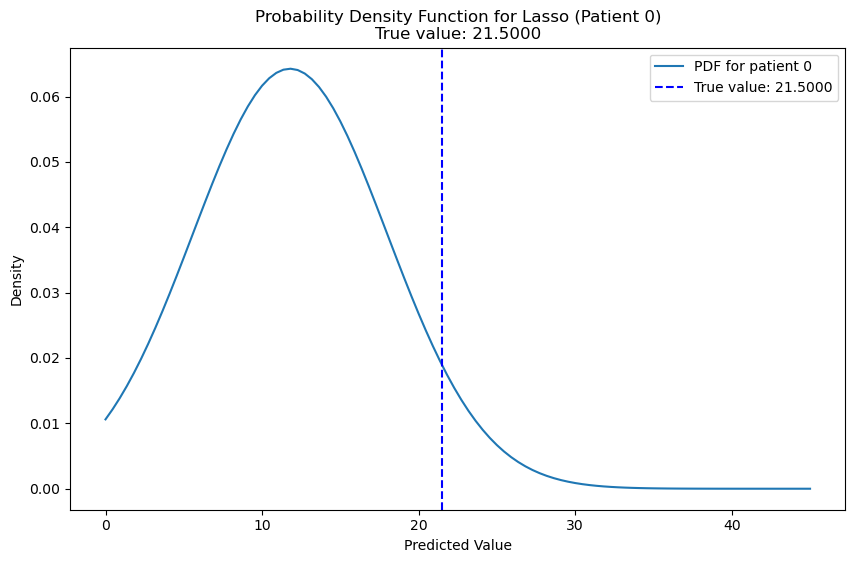

In [60]:
evaluator = ModelEvaluator(X, y)

# Save PDF data for all patients
evaluator.save_all_pdf_data("Lasso")

# Plot PDF for a specific patient
evaluator.plot_pdf("Lasso", patient_index=0)
